# Self-Attention Controllability Theorem Measurement in Llama-3 8b

In this notebook we will demonstrate the self-attention controllability theorem 
on GPT-2. 

We begin by extracting a single attention head from the model. For a given 
input token sequence x_0, we will compute the value of $\beta_i(k, \mathbf X)$, 
which should tell us which output representations $\mathbf Y^*$ are reachable 
given $k$ 

## Background

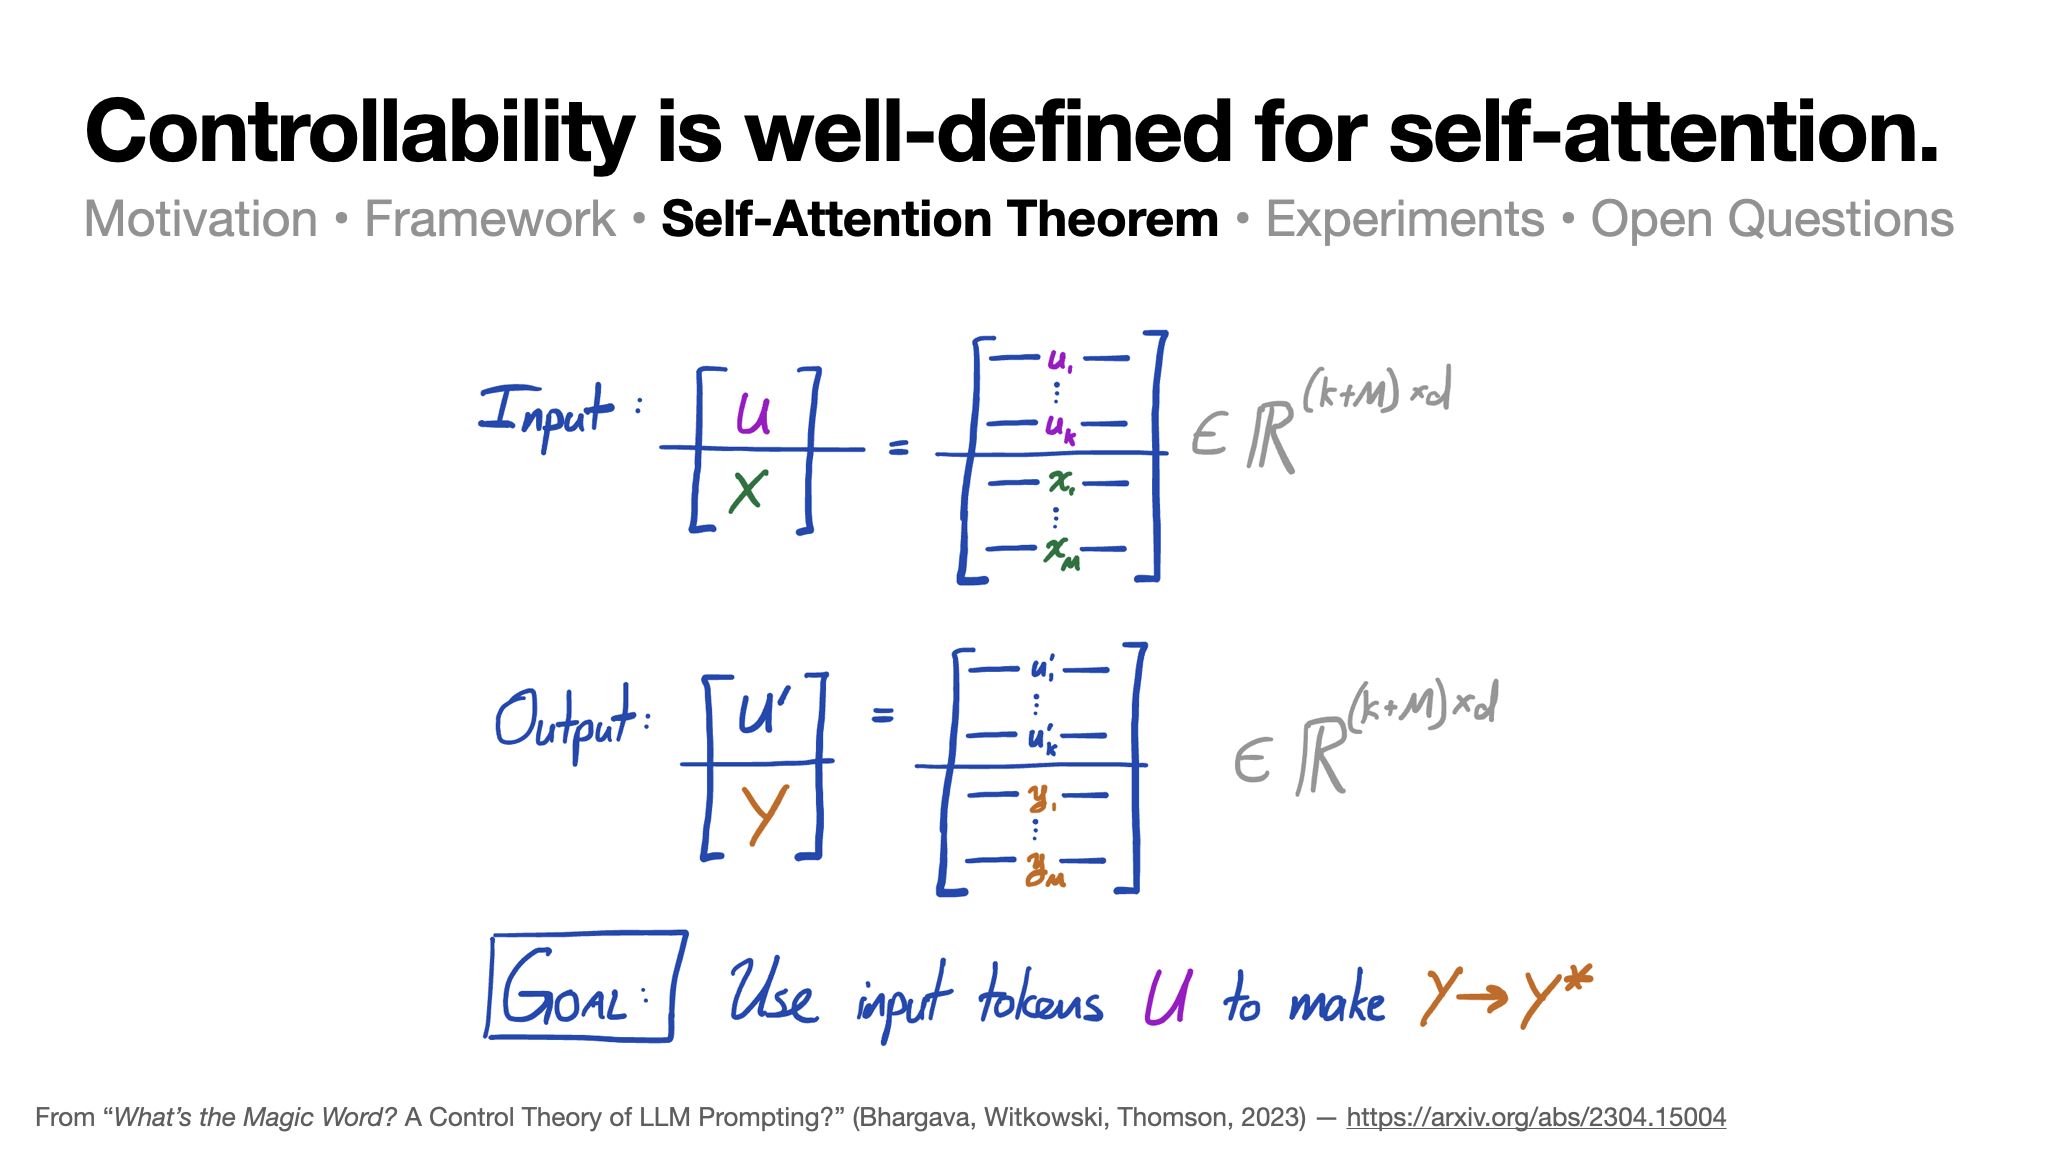

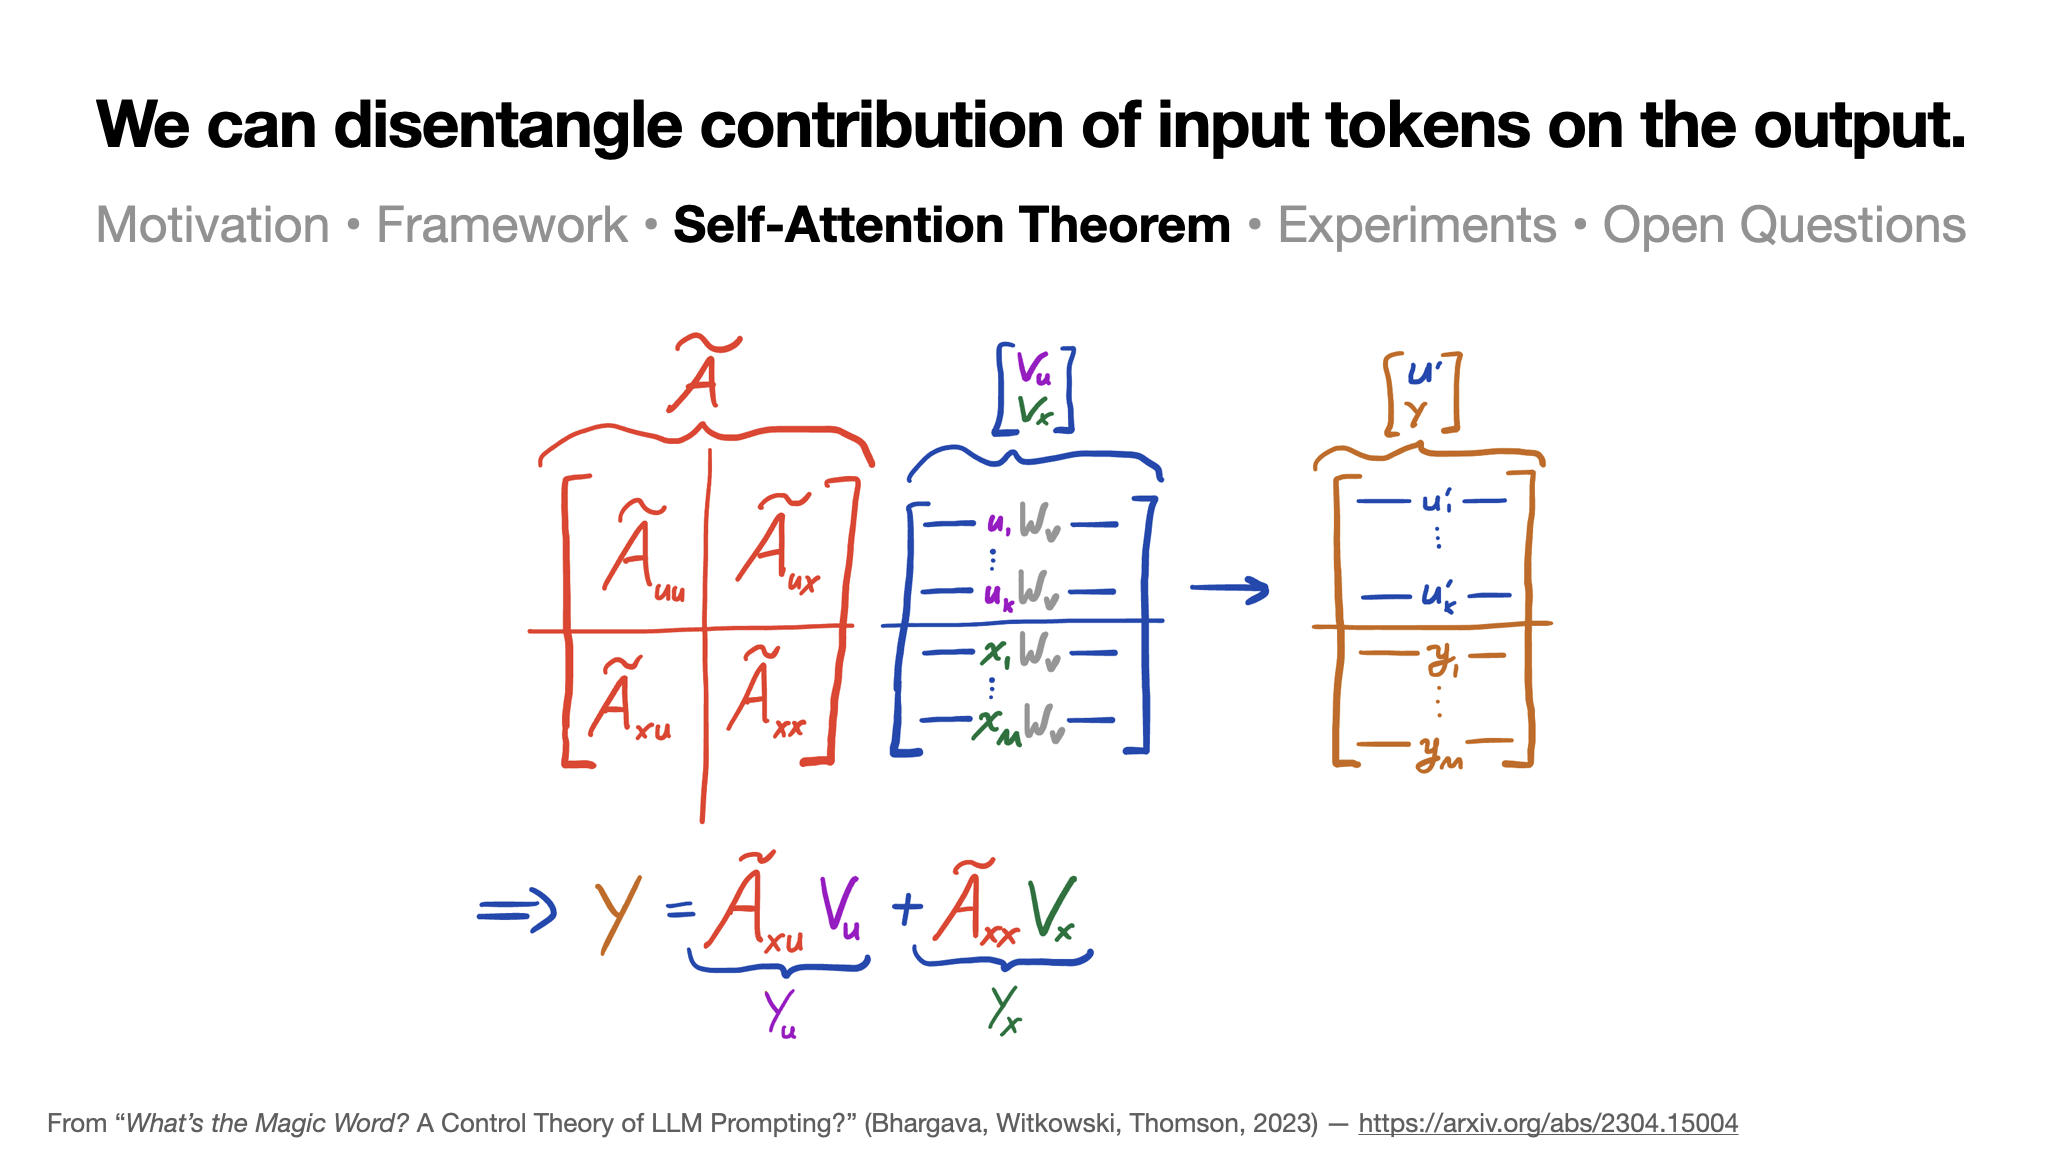

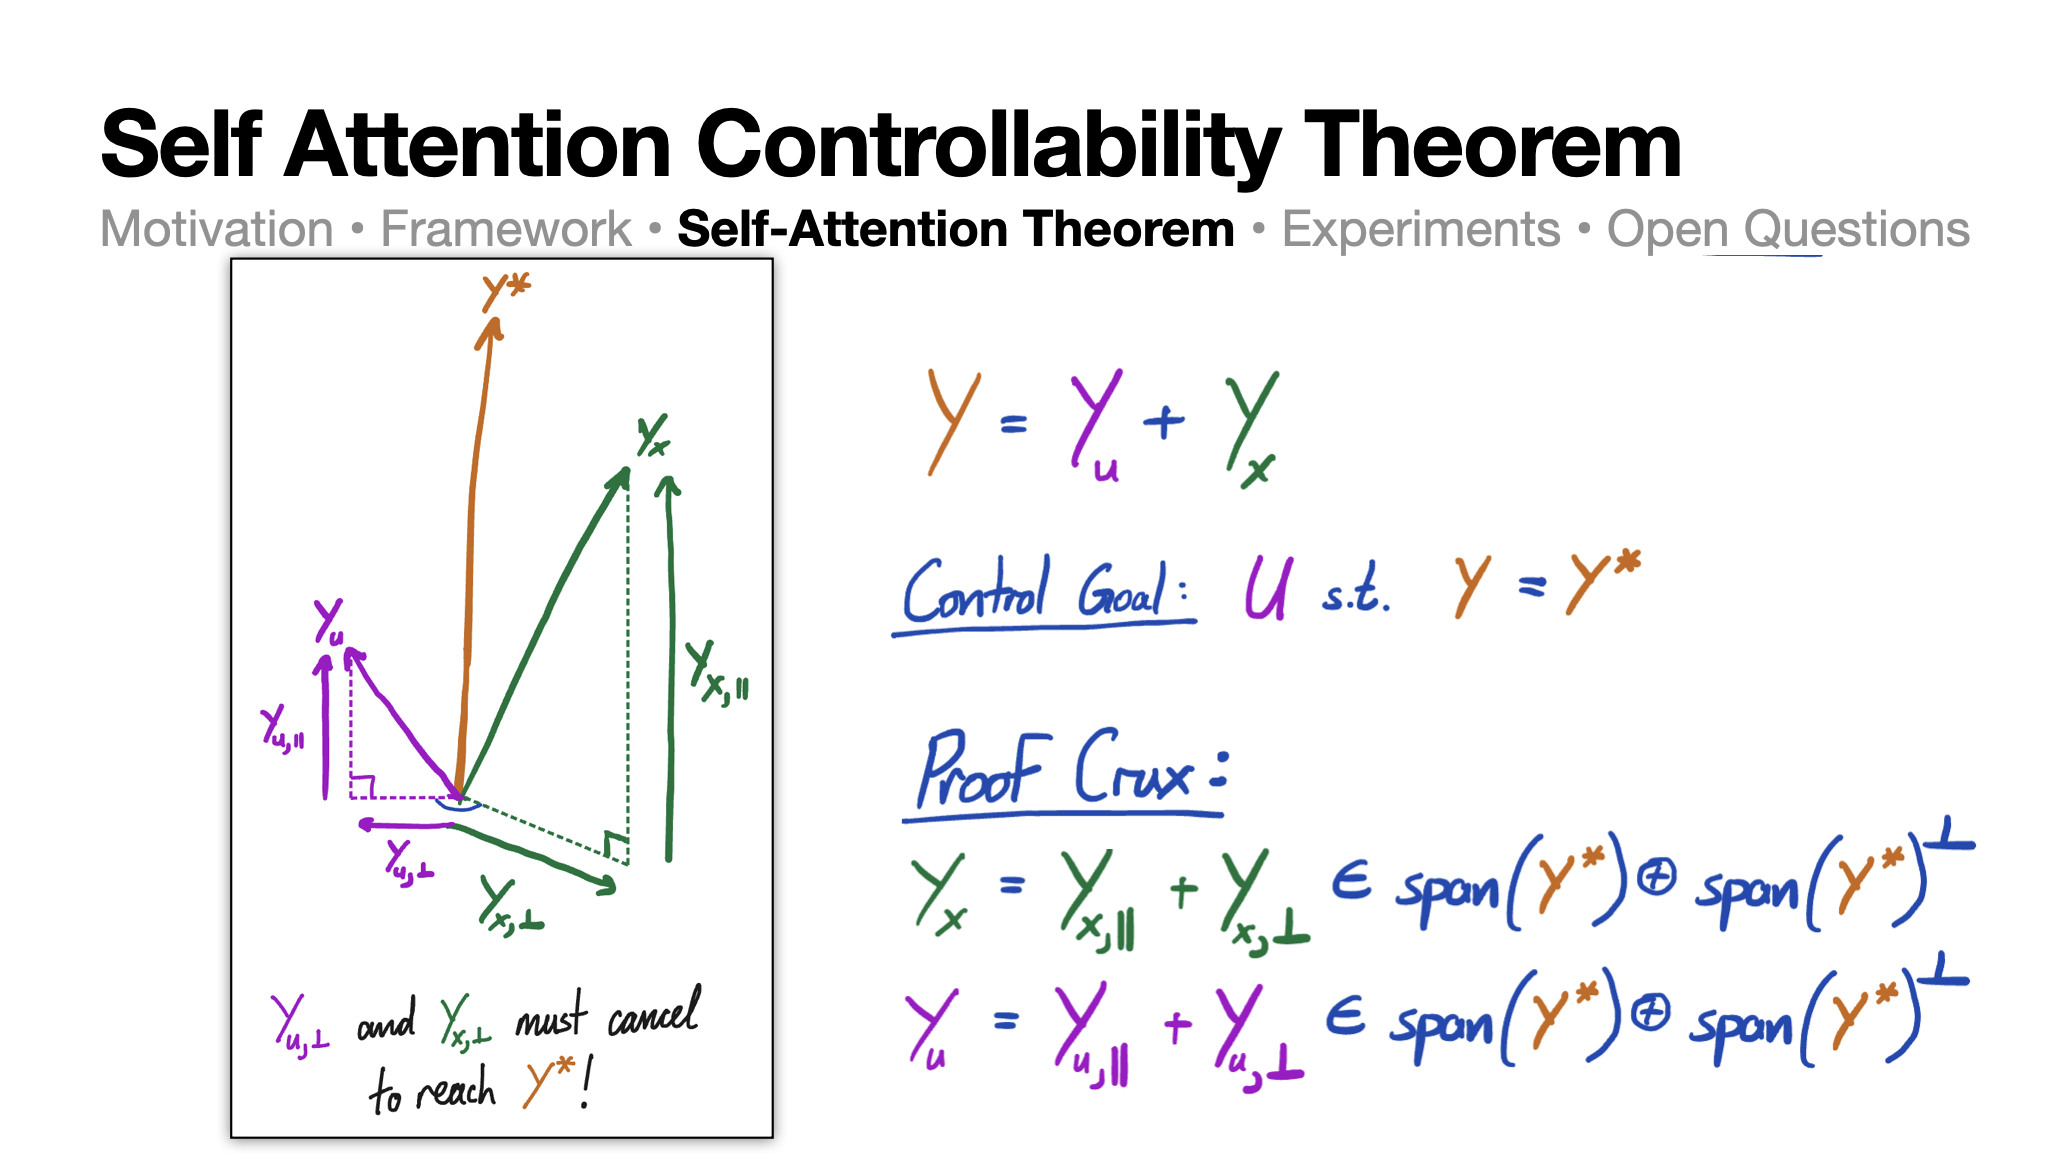

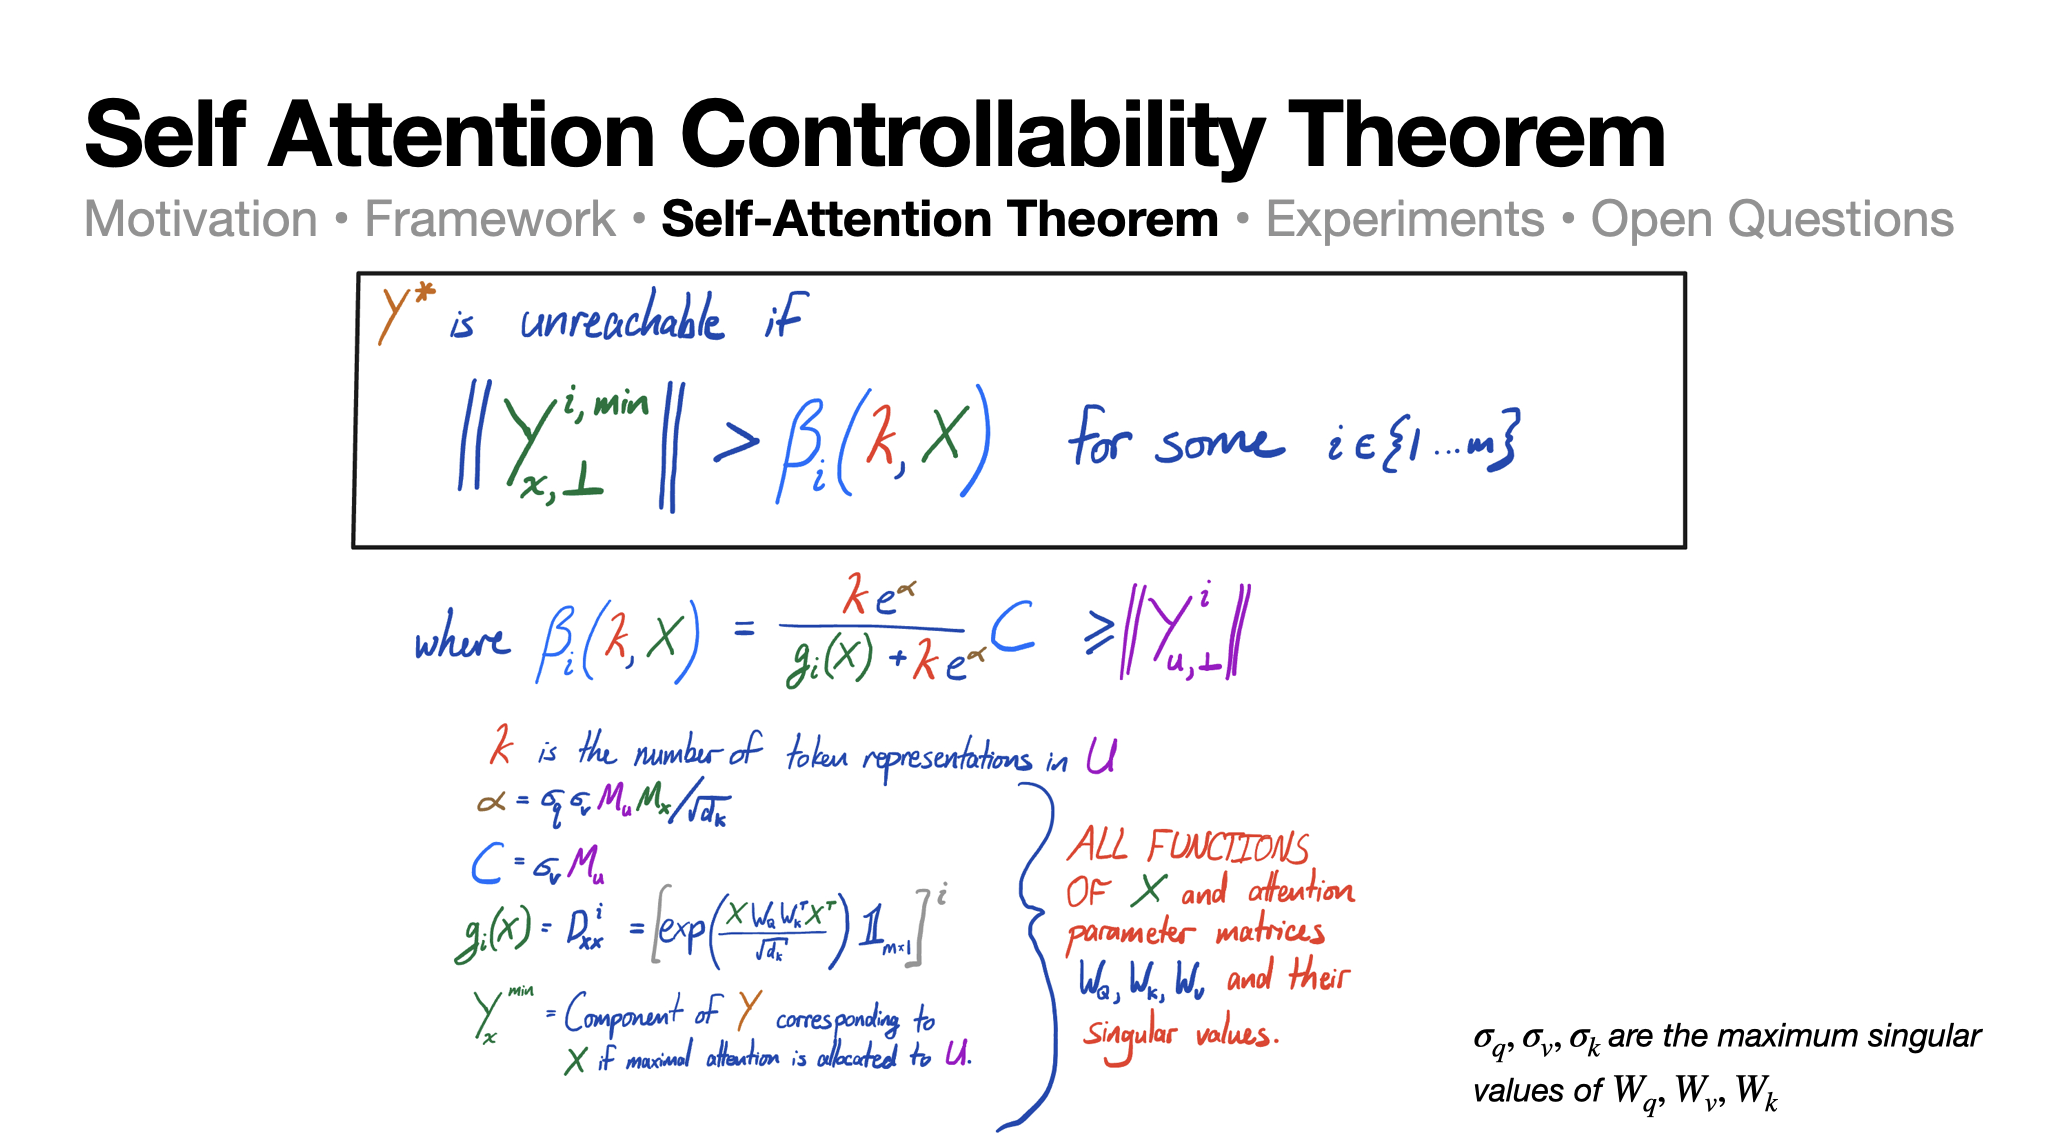

## Loading Llama-3 8b

In [1]:
# Import box 
import torch 
import numpy 
import transformers 
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM

/home/paperspace/Magic_Words/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "meta-llama/Meta-Llama-3-8B"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# if on CUDA 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm

Now we put through some input token sequence `x_0 = "I am become death, destroyer of worlds."`

In [3]:
x_0 = "I am become death, destroyer of worlds."
x_0_ids = tokenizer.encode(x_0, return_tensors="pt").to(device)
# get the activations 
with torch.no_grad():
    outputs = model(x_0_ids, output_hidden_states=True)

print("Outputs keys: ", outputs.keys())

Outputs keys:  odict_keys(['logits', 'past_key_values', 'hidden_states'])


In [12]:
len(outputs['past_key_values'])

32

Hidden state 0 shape:  torch.Size([1, 9, 4096])
=== 0 ===
Argmax of ipr:  40
Decoded argmax of ipr:  I
=== 1 ===
Argmax of ipr:  1097
Decoded argmax of ipr:   am
=== 2 ===
Argmax of ipr:  3719
Decoded argmax of ipr:   become
=== 3 ===
Argmax of ipr:  4648
Decoded argmax of ipr:   death
=== 4 ===
Argmax of ipr:  11
Decoded argmax of ipr:  ,
=== 5 ===
Argmax of ipr:  96289
Decoded argmax of ipr:   destroyer
=== 6 ===
Argmax of ipr:  315
Decoded argmax of ipr:   of
=== 7 ===
Argmax of ipr:  24800
Decoded argmax of ipr:   worlds
=== 8 ===
Argmax of ipr:  13
Decoded argmax of ipr:  .


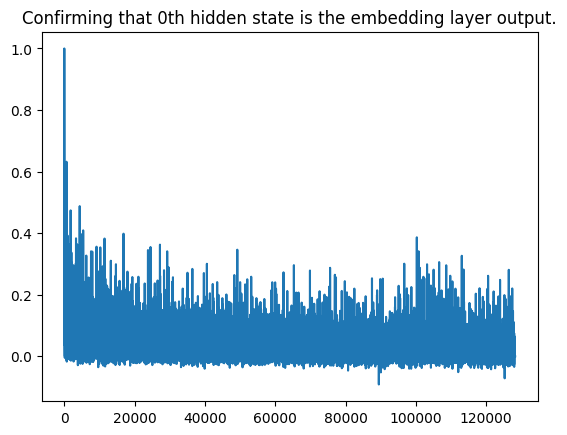

In [43]:
print("Hidden state 0 shape: ", outputs['hidden_states'][0].shape)
# compare to model.model.embed_tokens 
embed_toks = model.model.embed_tokens.weight # [|V|, d_model]
# normalize each |V| rows 
embed_toks = torch.nn.functional.normalize(embed_toks, p=2, dim=1)

for i in range(outputs['hidden_states'][0].shape[1]):
    vec_0 = outputs['hidden_states'][0][0, i, :]
    # normalize vec_0
    vec_0 = torch.nn.functional.normalize(vec_0, p=2, dim=0)
    # print("vec_0 norm: ", torch.norm(vec_0, p=2))


    # compute cosine similarity
    ipr = embed_toks @ vec_0
    print(f"=== {i} ===")
    print("Argmax of ipr: ", torch.argmax(ipr).item())
    print("Decoded argmax of ipr: ", tokenizer.decode(torch.argmax(ipr).item()))

    # plot 
plt.plot(ipr.detach().cpu().numpy())
plt.title("Confirming that 0th hidden state is the embedding layer output.")
plt.show()

Let's see if we can compute the singular values of the weight value weight matrices. 

In [25]:
outputs['logits'].argmax(-1)

tensor([[ 1097,   539,   264,    11,   279,   315, 24800,  2029,   482]],
       device='cuda:0')

In [21]:
print(type(model.model.layers[0]))

<class 'transformers.models.llama.modeling_llama.LlamaDecoderLayer'>


In [22]:
# get the 1st attention head
layer_num = len(model.model.layers)-1
head_num = 0

# get the layer 
print(model.model.layers[layer_num].self_attn)
print("Num heads: ", model.model.layers[layer_num].self_attn.num_heads)

LlamaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (rotary_emb): LlamaRotaryEmbedding()
)
Num heads:  32


In [17]:
model.model.layers[layer_num].self_attn
# we will input past key value (value) of the 2nd to last layer 
# as the 

transformers.models.llama.modeling_llama.LlamaAttention